In [1]:
from ipynb.fs.full.sim import Simulator
from ipynb.fs.full.traffic import Frame
from ipynb.fs.full.logger import Logger
from ipynb.fs.full.topology import SinkSwitch, BasicSwitch, Link, TrafficSource, ImpairedBasicSwitch
from ipynb.fs.full.frer import FRERSwitch, FRERMerge, FRERSplit
from ipynb.fs.full.ats import ATSGroup, ATSSwitch
import pandas as pd

## Test Case 1: Bounded Latency ##
Simpelst Test Case: latency is bounded due to not adversary frames and sufficient ATS configuration

- No Adversarial frames
- FRER for 2 different paths
- no delays, no drops
- single ATS group
- no stream interval enforcing in ats (cir and cbs big enough)
- L = 2.5s
- T < 3L = 7s

In [2]:
sim = Simulator()
logger = Logger()
sink_logger = Logger()
ats_logger = Logger()

L = 2.5
T = 7
sim_time = 200

# Links
link_src1_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src2_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src3_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)

link_sw0_l1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_sw0_s1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_l1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_s1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_sw1_sw2 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)

link_sw2_sink = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)


# Sink
sink = SinkSwitch("SINK", sim, logger)
sink_in = sink.add_ingress_port("in")
link_sw2_sink.connect(sink, sink_in)


# ATS
ats_groups = {"G1": ATSGroup(cir_bps=800, cbs_bytes=80, max_residence_time=10000)}
routing_table = {"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}
stream_to_group = {"Red": "G1", "Orange": "G1", "Blue": "G1"}
stream_interval = {"Red": L, "Orange": L, "Blue": L}

sw2 = ATSSwitch("ATS", sim, logger, routing_table, stream_to_group, ats_groups, stream_interval)
ats_in = sw2.add_ingress_port("in")
link_sw1_sw2.connect(sw2, ats_in)
sw2.add_egress_port("out", link_sw2_sink)


# FRER
split = FRERSplit({"Blue": ["out1", "out2"], "Red": ["out1"], "Orange": ["out1"]})

sw0 = FRERSwitch("SW_SPLIT", sim, logger, routing_table={}, frer_split=split)
split_in = sw0.add_ingress_port("in")
link_src1_sw0.connect(sw0, split_in)
link_src2_sw0.connect(sw0, split_in)
link_src3_sw0.connect(sw0, split_in)
sw0.add_egress_port("out1", link_sw0_l1)
sw0.add_egress_port("out2", link_sw0_s1)

merge = FRERMerge(expire_time=6.0)

sw1 = FRERSwitch("SW_MERGE", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}, frer_merge=merge)
merge_in = sw1.add_ingress_port("in")
link_l1_sw1.connect(sw1, merge_in)
link_s1_sw1.connect(sw1, merge_in)
sw1.add_egress_port("out", link_sw1_sw2)


# Switches
l1 = BasicSwitch("L1", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]})
l1_in = l1.add_ingress_port("in")
link_sw0_l1.connect(l1, l1_in)
l1.add_egress_port("out", link_l1_sw1)

s1 = BasicSwitch("S1", sim, logger, routing_table={"Blue": ["out"]})
s1_in = s1.add_ingress_port("in")
link_sw0_s1.connect(s1, s1_in)
s1.add_egress_port("out", link_s1_sw1)


# Sources
src1 = TrafficSource("BLUE", sim, logger)
src2 = TrafficSource("RED", sim, logger)
src3 = TrafficSource("ORANGE", sim, logger)
src1.add_egress_port("out", link_src1_sw0)
src2.add_egress_port("out", link_src2_sw0)
src3.add_egress_port("out", link_src3_sw0)

src1.start_periodic_loop(stream_id="Blue", frames_per_period=2, period=T, interval=L, size=10, offset=0.0) # count=10
src2.start_periodic_loop(stream_id="Red", frames_per_period=2, period=T, interval=L, size=10, offset=2.0)
src3.start_periodic_loop(stream_id="Orange", frames_per_period=2, period=T, interval=L, size=10, offset=4.5)


sim.run(until=sim_time)
"""
with pd.option_context(
    "display.max_columns", None,
    "display.max_rows", None,
    "display.max_colwidth", None,
    "display.width", None,
):
    display(sink_logger.to_dataframe())
    display(ats_logger.to_dataframe())
"""
logger.to_dataframe()

,time,node,event,frame_id,stream_id,port
0,0.00,BLUE,FORWARD,1,Blue,out
1,0.00,SW_SPLIT,RECEIVE,1,Blue,in
2,0.00,SW_SPLIT,FORWARD,1,Blue,out1
3,0.00,SW_SPLIT,FORWARD,1,Blue,out2
4,0.11,S1,RECEIVE,1,Blue,in
...,...,...,...,...,...,...
2166,199.22,ATS,FORWARD,1,Red,out
2167,199.22,SINK,RECEIVE,1,Red,in
2168,199.22,SINK,SINK,1,Red,in
2169,199.30,SW_MERGE,RECEIVE,2,Blue,in


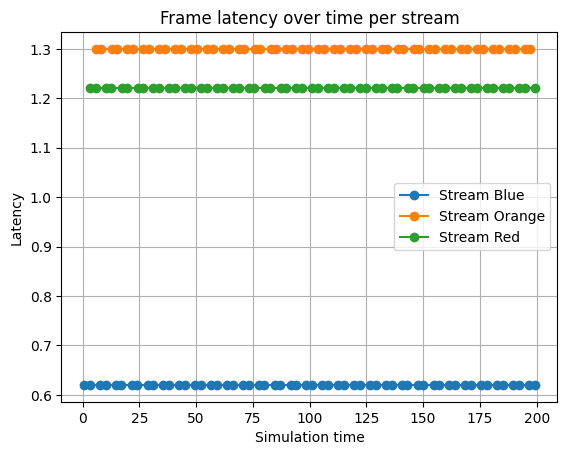

In [3]:
logger.plot_latencies()

## Test Case 2: UnBounded Latency ##
Test Case: latency is unbounded due to adversary frames and not sufficient ATS configuration

- Adversarial frames
- FRER for 2 different paths
- every 2-nd frame on short path is droped
- single ats group
- L stream interval enforcing in ats 
- L = 2.5s
- T < 3L = 7s


In [4]:
sim = Simulator()
logger = Logger()
sink_logger = Logger()
ats_logger = Logger()
drop_logger = Logger()

L = 2.5
T = 7
sim_time = 200

# Links
link_src1_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src2_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src3_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)

link_sw0_l1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_sw0_s1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_l1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_s1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_sw1_sw2 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)

link_sw2_sink = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)


# Sink
sink = SinkSwitch("SINK", sim, logger)
sink_in = sink.add_ingress_port("in")
link_sw2_sink.connect(sink, sink_in)


# ATS
ats_groups = {"G1": ATSGroup(cir_bps=800, cbs_bytes=80, max_residence_time=10000)}
routing_table = {"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}
stream_to_group = {"Red": "G1", "Orange": "G1", "Blue": "G1"}
stream_interval = {"Red": L, "Orange": L, "Blue": L}

sw2 = ATSSwitch("ATS", sim, logger, routing_table, stream_to_group, ats_groups, stream_interval)
ats_in = sw2.add_ingress_port("in")
link_sw1_sw2.connect(sw2, ats_in)
sw2.add_egress_port("out", link_sw2_sink)


# FRER
split = FRERSplit({"Blue": ["out1", "out2"], "Red": ["out1"], "Orange": ["out1"]})

sw0 = FRERSwitch("SW_SPLIT", sim, logger, routing_table={}, frer_split=split)
split_in = sw0.add_ingress_port("in")
link_src1_sw0.connect(sw0, split_in)
link_src2_sw0.connect(sw0, split_in)
link_src3_sw0.connect(sw0, split_in)
sw0.add_egress_port("out1", link_sw0_l1)
sw0.add_egress_port("out2", link_sw0_s1)

merge = FRERMerge(expire_time=6.0)

sw1 = FRERSwitch("SW_MERGE", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}, frer_merge=merge)
merge_in = sw1.add_ingress_port("in")
link_l1_sw1.connect(sw1, merge_in)
link_s1_sw1.connect(sw1, merge_in)
sw1.add_egress_port("out", link_sw1_sw2)


# Switches
l1 = BasicSwitch("L1", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]})
l1_in = l1.add_ingress_port("in")
link_sw0_l1.connect(l1, l1_in)
l1.add_egress_port("out", link_l1_sw1)

s1 = ImpairedBasicSwitch("S1", sim, logger, routing_table={"Blue": ["out"]}, impair_every_n=2, impair_mode="drop")
s1_in = s1.add_ingress_port("in")
link_sw0_s1.connect(s1, s1_in)
s1.add_egress_port("out", link_s1_sw1)


# Sources
src1 = TrafficSource("BLUE", sim, logger)
src2 = TrafficSource("RED", sim, logger)
src3 = TrafficSource("ORANGE", sim, logger)
src1.add_egress_port("out", link_src1_sw0)
src2.add_egress_port("out", link_src2_sw0)
src3.add_egress_port("out", link_src3_sw0)

src1.start_periodic_loop(stream_id="Blue", frames_per_period=2, period=T, interval=L, size=10, offset=0.0) # count=10
src2.start_periodic_loop(stream_id="Red", frames_per_period=2, period=T, interval=L, size=10, offset=2.0)
src3.start_periodic_loop(stream_id="Orange", frames_per_period=2, period=T, interval=L, size=10, offset=4.5)


sim.run(until=sim_time)
"""
with pd.option_context(
    "display.max_columns", None,
    "display.max_rows", None,
    "display.max_colwidth", None,
    "display.width", None,
):
    display(logger.to_dataframe())
"""
logger.to_dataframe()

,time,node,event,frame_id,stream_id,port
0,0.00,BLUE,FORWARD,1,Blue,out
1,0.00,SW_SPLIT,RECEIVE,1,Blue,in
2,0.00,SW_SPLIT,FORWARD,1,Blue,out1
3,0.00,SW_SPLIT,FORWARD,1,Blue,out2
4,0.11,S1,RECEIVE,1,Blue,in
...,...,...,...,...,...,...
2072,198.90,L1,FORWARD,2,Blue,out
2073,199.12,ATS,RECEIVE,2,Blue,in
2074,199.22,ATS,RECEIVE,1,Red,in
2075,199.30,SW_MERGE,RECEIVE,2,Blue,in


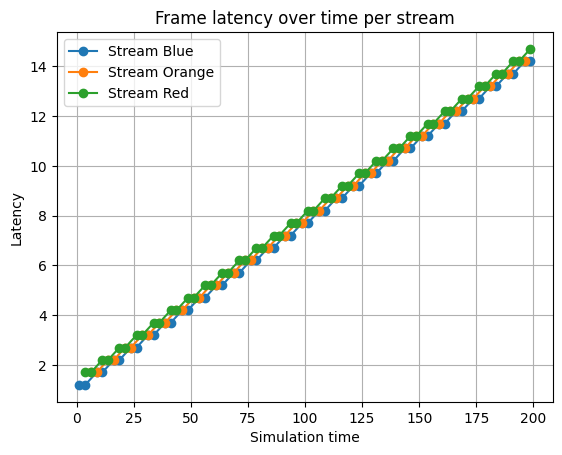

In [5]:
logger.plot_latencies()

## Test Case 3: Bounded Latency MRT ##
Test Case: latency is bounded due to MRT 

- Adversarial frames
- FRER for 2 different paths
- every 2-nd frame on short path is droped
- single ats group
- L stream interval enforcing in ats 
- L = 2.5s
- T < 3L = 7s
- MRT = 10s

In [8]:
sim = Simulator()
logger = Logger()
sink_logger = Logger()
ats_logger = Logger()
drop_logger = Logger()

L = 2.5
T = 7
sim_time = 200

# Links
link_src1_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src2_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)
link_src3_sw0 = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)

link_sw0_l1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_sw0_s1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_l1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)
link_s1_sw1 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.01)

link_sw1_sw2 = Link(sim, bitrate_bps=800, transmission_delay_enabled=True, propagation_delay=0.3)

link_sw2_sink = Link(sim, bitrate_bps=800, transmission_delay_enabled=False, propagation_delay=0.0)


# Sink
sink = SinkSwitch("SINK", sim, logger)
sink_in = sink.add_ingress_port("in")
link_sw2_sink.connect(sink, sink_in)


# ATS
ats_groups = {"G1": ATSGroup(cir_bps=800, cbs_bytes=80, max_residence_time=10)}
routing_table = {"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}
stream_to_group = {"Red": "G1", "Orange": "G1", "Blue": "G1"}
stream_interval = {"Red": L, "Orange": L, "Blue": L}

sw2 = ATSSwitch("ATS", sim, logger, routing_table, stream_to_group, ats_groups, stream_interval)
ats_in = sw2.add_ingress_port("in")
link_sw1_sw2.connect(sw2, ats_in)
sw2.add_egress_port("out", link_sw2_sink)


# FRER
split = FRERSplit({"Blue": ["out1", "out2"], "Red": ["out1"], "Orange": ["out1"]})

sw0 = FRERSwitch("SW_SPLIT", sim, logger, routing_table={}, frer_split=split)
split_in = sw0.add_ingress_port("in")
link_src1_sw0.connect(sw0, split_in)
link_src2_sw0.connect(sw0, split_in)
link_src3_sw0.connect(sw0, split_in)
sw0.add_egress_port("out1", link_sw0_l1)
sw0.add_egress_port("out2", link_sw0_s1)

merge = FRERMerge(expire_time=6.0)

sw1 = FRERSwitch("SW_MERGE", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]}, frer_merge=merge)
merge_in = sw1.add_ingress_port("in")
link_l1_sw1.connect(sw1, merge_in)
link_s1_sw1.connect(sw1, merge_in)
sw1.add_egress_port("out", link_sw1_sw2)


# Switches
l1 = BasicSwitch("L1", sim, logger, routing_table={"Blue": ["out"], "Red": ["out"], "Orange": ["out"]})
l1_in = l1.add_ingress_port("in")
link_sw0_l1.connect(l1, l1_in)
l1.add_egress_port("out", link_l1_sw1)

s1 = ImpairedBasicSwitch("S1", sim, logger, routing_table={"Blue": ["out"]}, impair_every_n=2, impair_mode="drop")
s1_in = s1.add_ingress_port("in")
link_sw0_s1.connect(s1, s1_in)
s1.add_egress_port("out", link_s1_sw1)


# Sources
src1 = TrafficSource("BLUE", sim, logger)
src2 = TrafficSource("RED", sim, logger)
src3 = TrafficSource("ORANGE", sim, logger)
src1.add_egress_port("out", link_src1_sw0)
src2.add_egress_port("out", link_src2_sw0)
src3.add_egress_port("out", link_src3_sw0)

src1.start_periodic_loop(stream_id="Blue", frames_per_period=2, period=T, interval=L, size=10, offset=0.0) # count=10
src2.start_periodic_loop(stream_id="Red", frames_per_period=2, period=T, interval=L, size=10, offset=2.0)
src3.start_periodic_loop(stream_id="Orange", frames_per_period=2, period=T, interval=L, size=10, offset=4.5)


sim.run(until=sim_time)
"""
with pd.option_context(
    "display.max_columns", None,
    "display.max_rows", None,
    "display.max_colwidth", None,
    "display.width", None,
):
    display(logger.to_dataframe())
"""
logger.to_dataframe()

,time,node,event,frame_id,stream_id,port
0,0.00,BLUE,FORWARD,1,Blue,out
1,0.00,SW_SPLIT,RECEIVE,1,Blue,in
2,0.00,SW_SPLIT,FORWARD,1,Blue,out1
3,0.00,SW_SPLIT,FORWARD,1,Blue,out2
4,0.11,S1,RECEIVE,1,Blue,in
...,...,...,...,...,...,...
2081,198.90,L1,FORWARD,2,Blue,out
2082,199.12,ATS,RECEIVE,2,Blue,in
2083,199.22,ATS,RECEIVE,1,Red,in
2084,199.30,SW_MERGE,RECEIVE,2,Blue,in


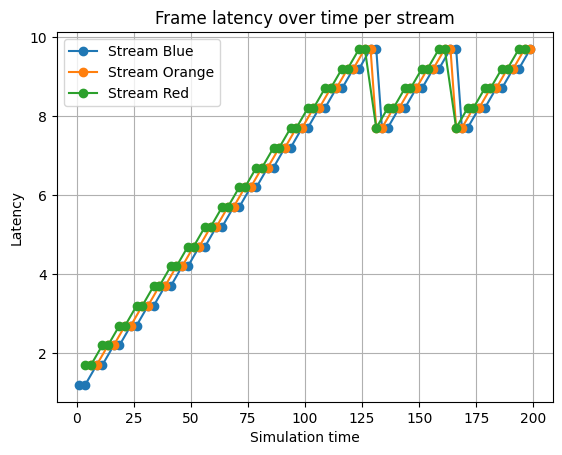

In [9]:
logger.plot_latencies()